# Estruturas para implementação de Filtros IIR

**Disciplina:** ENGG54 - Laboratório Integrado III-A - 2021.2

**Docente:** Paulo Farias

**Discentes:** Ana Clara Batista, André Paiva, Andrey Fontoura, Ariel Lima, Douglas Leite, Guilherme Costa, Jeferson Novaes, João Victor Carneiro, Pedro Augusto Correia, Pedro Freitas

## 1 - Inicialização

### 1.1 - Importação de bibliotecas

In [115]:
import numpy as np
from scipy import signal, misc, fftpack
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy.fft import fft, fftfreq
import warnings
warnings.filterwarnings('ignore')

## 2 - Funções usadas na simulação

### 2.1 - Funções Auxiliares

#### 2.1.1 - Funções de plotagem

In [116]:
figsize = (15, 5)

def plotarSinal(dataset, titulo):
    figure(num=None, figsize=figsize, dpi=100, facecolor='w', edgecolor='k')
    t = np.linspace(0, len(dataset), len(dataset))
    plt.axhline(y=0, color='black', linestyle='-')
    plt.plot(t, dataset[:])    
    plt.title(titulo)
    plt.xlabel("Amostra")
    plt.ylabel("Amplitude")
    plt.show()
    
def plotarFuncaoContinua(data_function, title, N, step):
    figure(num=None, figsize=figsize, dpi=100, facecolor='w', edgecolor='k')
    x = np.arange(0, N, step)
    y = data_function(x)
    plt.axhline(y=0, color='black', linestyle='-')
    plt.plot(x, y)
    plt.title(title)
    plt.ylabel('Amplitude')
    plt.xlabel('Tempo t(s)')
    plt.show()
    
def plotarAmostras(data, title):
    figure(num=None, figsize=figsize, dpi=100, facecolor='w', edgecolor='k')
    plt.stem(data, linefmt='b-', basefmt='k-')
    plt.title(title)
    plt.ylabel('Amplitude')
    plt.xlabel('Amostra')
    plt.show()
    
def plotarSinalFreq(data, N, T, title):
    yf = fft(data)
    xf = fftfreq(N, T)[:N//2] 
    figure(num=None, figsize=figsize, dpi=100, facecolor='w', edgecolor='k')
    plt.axhline(y=0, color='black', linestyle='-')
    plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))    
    plt.title(title)
    plt.ylabel("FFT")
    plt.xlabel("Freq. [Hz]")
    plt.show()

def plotarFreqz(b, a, titulo):
    w, h = signal.freqz(b, a)
    fig, ax1 = plt.subplots()
    ax1.set_title(titulo)
    ax1.plot(w, 20.0 * np.log10(abs(h)), 'b')
    ax1.set_ylabel('Amplitude [dB]', color='b')
    ax1.set_xlabel('Frequência [rad/s]')
    ax1.grid()
    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    ax2.plot(w, angles, 'r')
    ax2.set_ylabel('Fase(rad)', color='r')
    ax2.axis('tight')
    plt.show()

def plotarSOS(sos, titulo):
    w, h = signal.sosfreqz(sos, worN=1500)
    fig, ax1 = plt.subplots()
    ax1.set_title(titulo)
    ax1.plot(w, 20.0 * np.log10(abs(h)), 'b')
    ax1.set_ylabel('Amplitude [dB]', color='b')
    ax1.set_xlabel('Frequência [rad/s]')
    ax1.grid()
    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    ax2.plot(w, angles, 'r')
    ax2.set_ylabel('Fase(rad)', color='r')
    ax2.axis('tight')
    plt.show()

#### 2.1.2 - Funções de cálculo

In [117]:
def float_to_q15(y):
    y_clamped = np.clip(y, -1.0, float.fromhex("0x0.fffe"))
    y_fixed = np.multiply(y_clamped, 32768).astype(np.int16)
    return y_fixed

def array_to_cdata(y):
    out_string = "{\n"
    for i in y:
        out_string += str(i)+",\n"
    out_string = out_string[:-2]
    out_string += "\n}\n"
    return out_string

## 3 - Datasets usados na simulação

### 3.1 - Soma de senoides

#### 3.1.1 - Parâmetros da soma de senoides

In [118]:
w_low_continuous = np.pi / 21.74
w_mid_continuous = np.pi / 2.85
w_high_continuous = np.pi / 1.1

ph_low_continuous = np.pi / 7
ph_mid_continuous = 0
ph_high_continuous = np.pi / 3

def sample_low(n):
    return np.sin((w_low_continuous * n) + ph_low_continuous)
    
def sample_mid(n):
    return np.sin((w_mid_continuous * n) + ph_mid_continuous)
                                       
def sample_high(n):
    return np.sin((w_high_continuous * n) + ph_high_continuous)

def sample_input_signal(n):
    return (sample_low(n) + sample_mid(n) + sample_high(n)) / 3.0

print("Sinal de baixa frequência: {0:.5}Hz".format(w_low_continuous / (2*np.pi)))
print("Sinal de média frequência: {0:.5}Hz".format(w_mid_continuous / (2*np.pi)))
print("Sinal de alta frequência: {0:.5}Hz".format(w_high_continuous / (2*np.pi)))

Sinal de baixa frequência: 0.022999Hz
Sinal de média frequência: 0.17544Hz
Sinal de alta frequência: 0.45455Hz


#### 3.1.2 - Composição da soma de senoides (sinal contínuo)

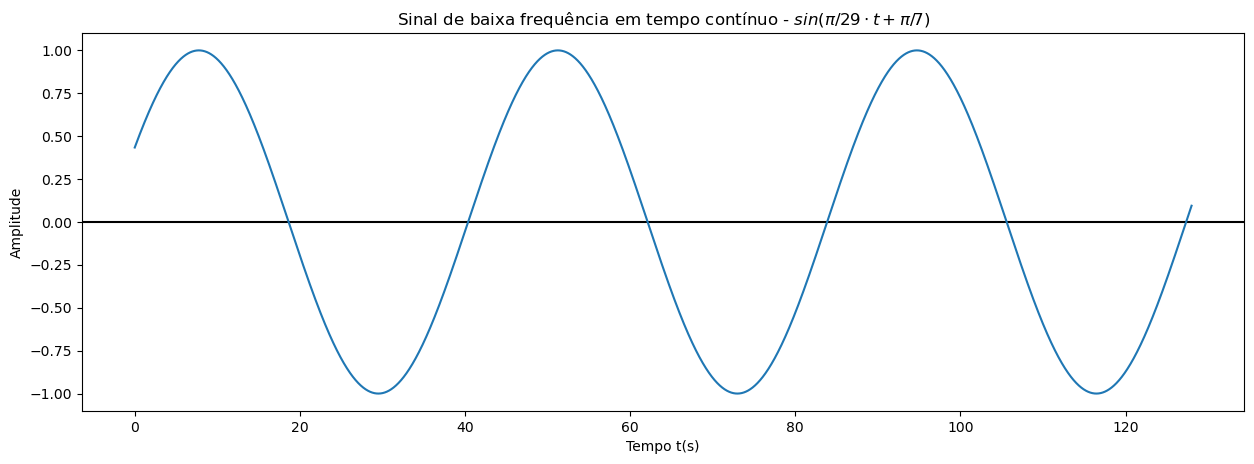

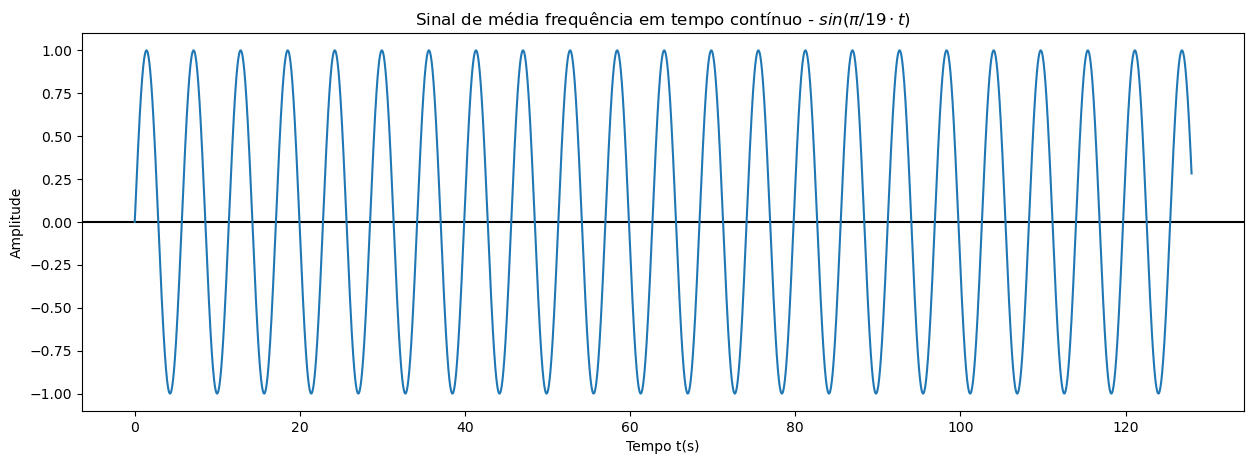

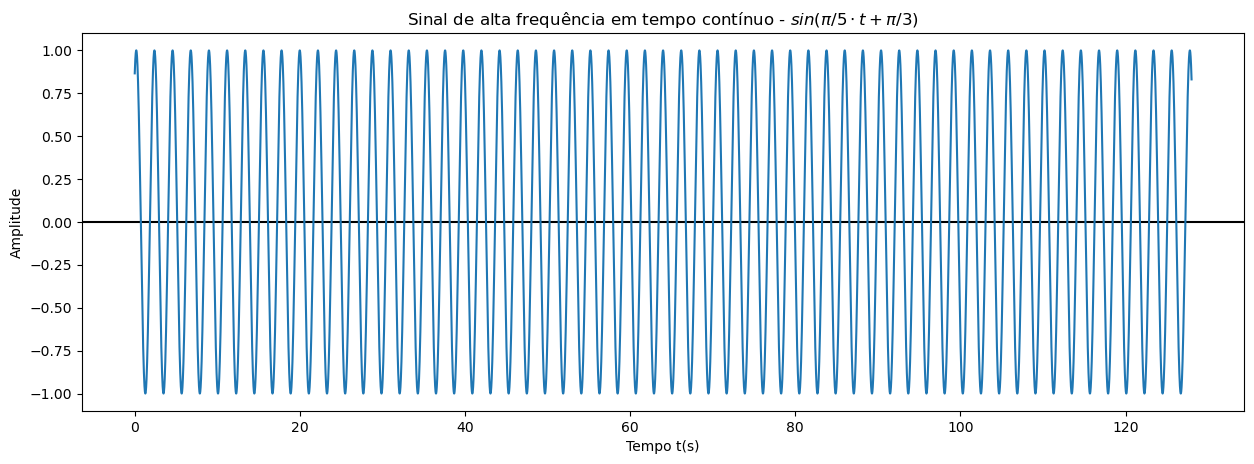

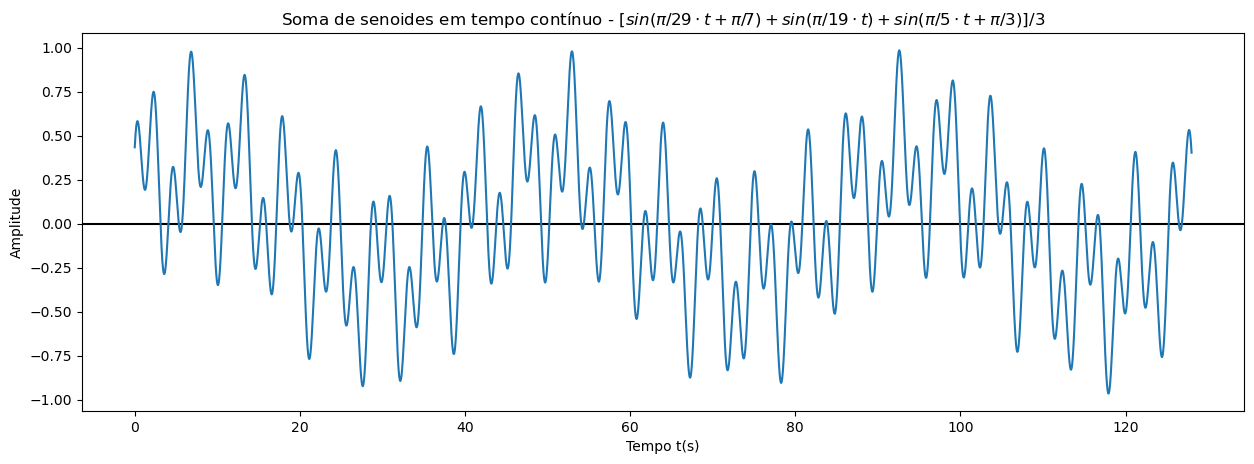

In [119]:
plotarFuncaoContinua(sample_low, "Sinal de baixa frequência em tempo contínuo - $sin(\pi/29 \cdot t + \pi/7)$", 128, 0.01)
plotarFuncaoContinua(sample_mid, "Sinal de média frequência em tempo contínuo - $sin(\pi/19 \cdot t)$", 128, 0.01)
plotarFuncaoContinua(sample_high, "Sinal de alta frequência em tempo contínuo - $sin(\pi/5 \cdot t + \pi/3)$", 128, 0.01)
plotarFuncaoContinua(sample_input_signal, "Soma de senoides em tempo contínuo - $[sin(\pi/29 \cdot t + \pi/7) + sin(\pi/19 \cdot t) + sin(\pi/5 \cdot t + \pi/3)] / 3$", 128, 0.01)

#### 3.1.3 - Amostragem da soma de senoides

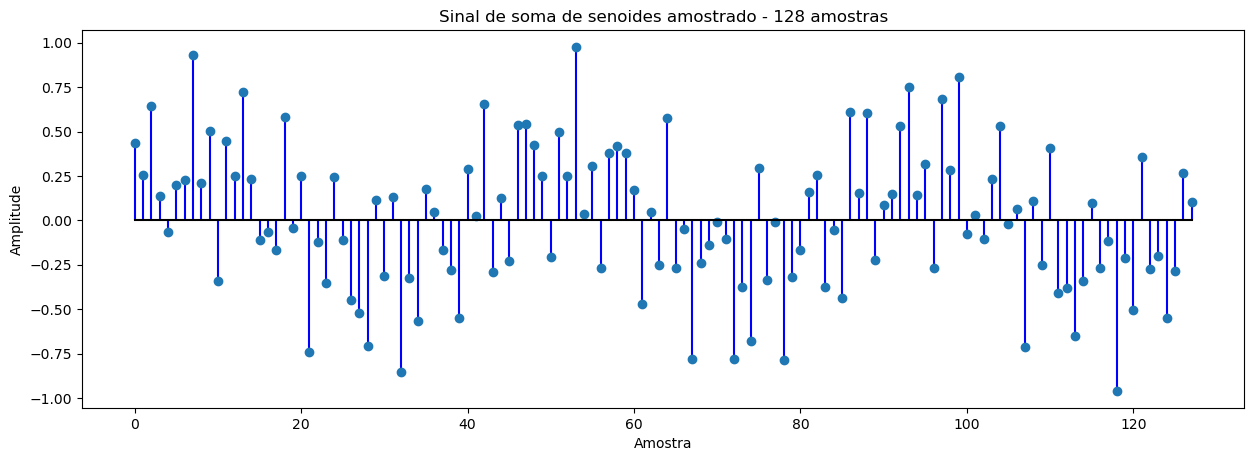

In [120]:
input_array = np.zeros(128)
for i in range(128):
    input_array[i] = sample_input_signal(i)
plotarAmostras(input_array, "Sinal de soma de senoides amostrado - 128 amostras")

#### 3.1.4 - Plotagem da soma de senoides no domínio da frequência

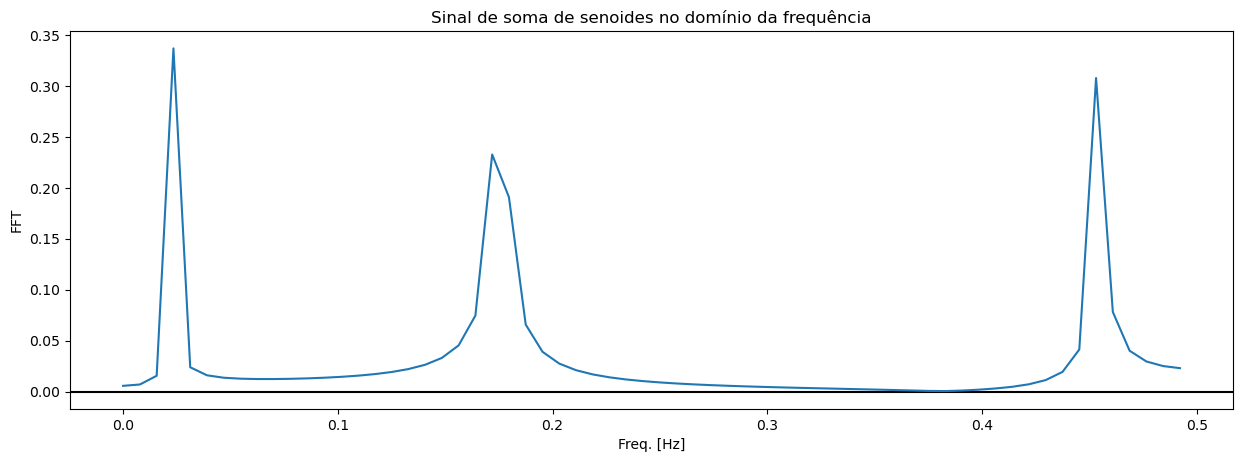

In [121]:
plotarSinalFreq(input_array, 128, 1, "Sinal de soma de senoides no domínio da frequência")

#### 3.1.5 - Vetor de amostras da soma de senoides e conversão para Q15

In [122]:
print("Vetor da soma de senoides:", input_array)
print()
input_array_Q15 = float_to_q15(input_array)
print("Vetor da soma de senoides convertido para Q15:", input_array_Q15)
print()
# Array no formato CDATA para utilização na placa
print(array_to_cdata(input_array_Q15))

Vetor da soma de senoides: [ 0.43330305  0.25376022  0.64555452  0.13945668 -0.06459964  0.1985456
  0.22473859  0.93300173  0.20807572  0.50233955 -0.34105634  0.44396947
  0.24752708  0.72228408  0.23453146 -0.10980331 -0.06443416 -0.16472998
  0.58109106 -0.04393309  0.2492341  -0.74094272 -0.12443732 -0.35375073
  0.24254503 -0.10934541 -0.44862129 -0.5200507  -0.70609921  0.11363431
 -0.31528389  0.13281486 -0.85474382 -0.32615781 -0.568349    0.17642248
  0.04522268 -0.16949455 -0.2769243  -0.55087239  0.29017448  0.02726922
  0.65578803 -0.29117299  0.12829062 -0.22817372  0.53710879  0.54270143
  0.4243306   0.24990776 -0.20826771  0.49641782  0.24877963  0.97375309
  0.0381784   0.30552094 -0.26977699  0.37727149  0.42104498  0.38190281
  0.16928888 -0.47074543  0.04459785 -0.24931484  0.57341652 -0.26900985
 -0.04746366 -0.77950379 -0.24005995 -0.13793926 -0.00734928 -0.10513463
 -0.78126144 -0.37397757 -0.68141881  0.29271947 -0.33744054 -0.00845338
 -0.7848263  -0.31967985 

### 3.2 - Sinal de amostras aleatórias

In [123]:
random_samples = [-0.1299932293737831, -0.20265844302767877, -0.8148970190249711, 0.993230079552021, 0.5222550196179643, -0.8526176406026489, -0.05299249409229523, 0.15988439811855137, 0.1413592629001481, 0.16294219666512633, -0.42912412197556304, -0.3896302812022303, -0.5188096782611629, -0.589712236263914, 0.8678859026315022, -0.9101625014598123, 0.053441177832854736, 0.4021673429291426, 0.5360216351325628, 0.5144038931493022, 0.5013246197625363, 0.03976760852248429, 0.1221476699198063, 0.8953527198779005, -0.847610521371752, -0.41274902740763886, -0.19627704694610193, 0.5204114181876809, -0.8751776919821124, 0.4354108776359311, 0.03426417650100744, -0.1964877185830698, -0.9608224520439139, 0.9846691369616143, 0.7090494796190812, -0.05743935399211697, 0.9133336930583273, -0.06580071517530439, 0.14641067172689826, -0.5582879607761413, -0.12938440222692305, -0.6853655535280134, 0.5459200963799704, -0.7733736467070587, 0.2859333796588177, 0.04081224676948758, -0.36178654332671956, 0.050398167183346, -0.8458886328752966, 0.8512798982997059, 0.02537066551137568, -0.682238016561268, 0.8756833032605313, -0.6567661575276948, 0.3745662381140886, 0.4784416087064238, 0.8266169739287887, 0.8177832890142793, -0.719981126265566, -0.8052373235535613, 0.9461165032146812, -0.1819549678146224, -0.311200920689932, 0.815816412461273, 0.12867968415281594, 0.6262294592527975, 0.5185815470723283, 0.30573847567335566, -0.42340236414982324, -0.8674005347133762, 0.22373608236105524, -0.8390675657785394, 0.22740368695466118, 0.18604159297244593, -0.7580387911804656, 0.49779620710275574, 0.6513429590257223, -0.7325005658987995, 0.8038762823076286, -0.9210571783943629, 0.45766744679744464, 0.591139758397409, 0.6734493392709984, -0.9811259759712676, -0.5439170936094473, 0.8466358634880711, -0.9200338915119184, -0.7726940652291681, -0.5693830888045088, -0.83631972081694, 0.6522356021896085, -0.6951991406797409, -0.4306324238378454, -0.8189240951561292, -0.23659404720643362, -0.10364821006376723, 0.498956166371173, -0.1276420155108926, -0.8493395619933364, -0.19192837304347643, 0.004081670303439644, 0.7341728258152065, 0.7314280389791128, 0.16808587514340445, -0.3467120711576088, 0.10735479615653665, -0.40146647446322015, 0.4730344245404279, -0.4703229830163185, 0.3990788591422929, 0.8949665211117515, 0.9809468003704334, -0.16310912658774912, 0.11599121833974357, -0.7198080980755956, -0.4607635392474325, -0.965777833765511, -0.953324143850848, 0.018872999754086184, 0.5527483894328551, 0.510921390673263, 0.49991639268595445, -0.8918238236240132, 0.6475972563686763, 0.37335537287444387, 0.9708334320913996, -0.800268205754086, 0.5845842775864385]

#### 3.2.1 - Plotagem da forma de onda do sinal aleatório

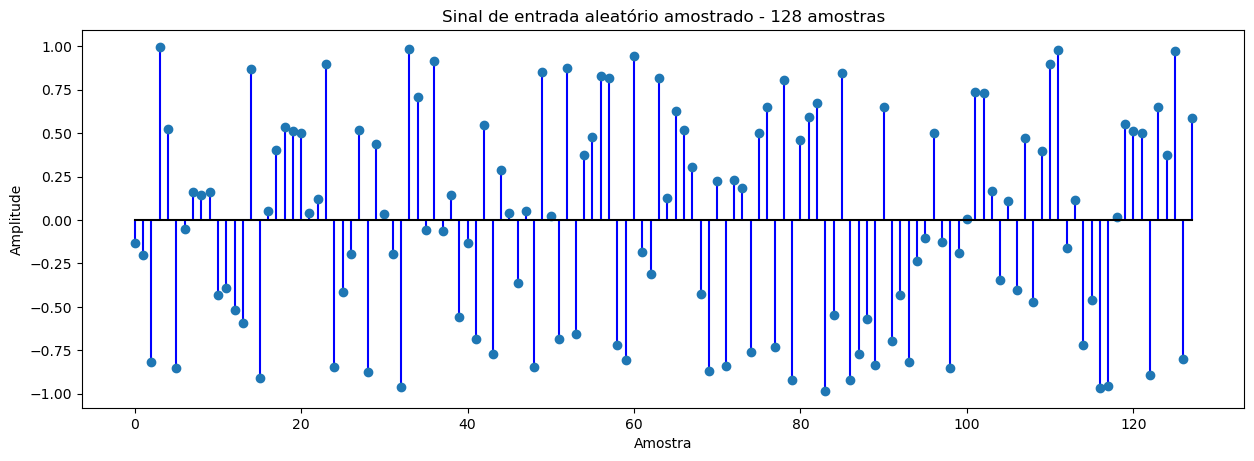

In [124]:
plotarAmostras(random_samples, "Sinal de entrada aleatório amostrado - 128 amostras")

#### 3.2.2 - Plotagem do sinal aleatório no domínio da frequência

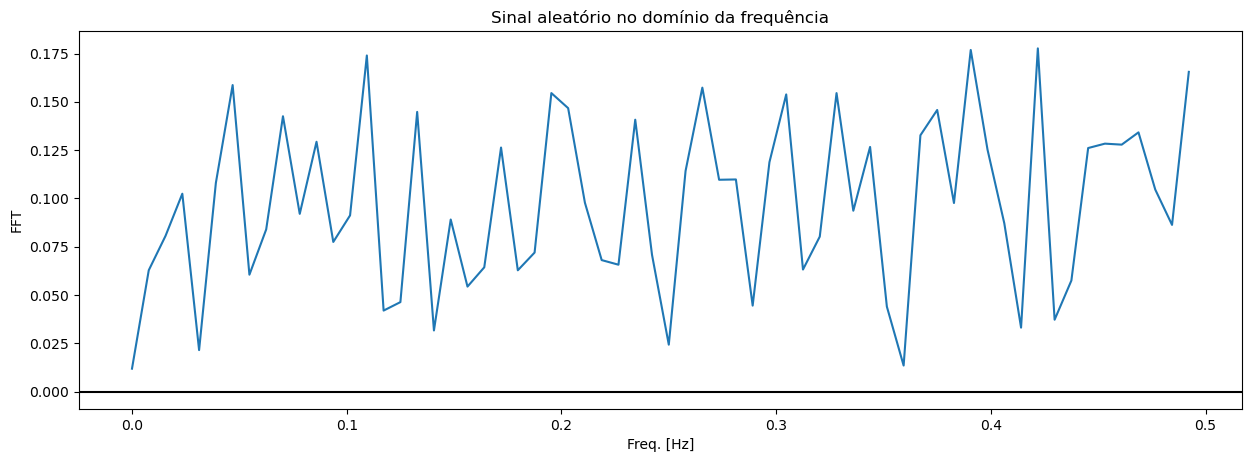

In [125]:
plotarSinalFreq(random_samples, 128, 1, "Sinal aleatório no domínio da frequência")

#### 3.2.3 Vetor de amostras do sinal aleatório e conversão para Q15

In [126]:
print("Vetor do sinal aleatório:", random_samples)
print()
random_samples_Q15 = float_to_q15(random_samples)
print("Vetor do sinal aleatório convertido para Q15:", random_samples_Q15)
print()
# Array no formato CDATA para utilização na placa
print(array_to_cdata(random_samples_Q15))

Vetor do sinal aleatório: [-0.1299932293737831, -0.20265844302767877, -0.8148970190249711, 0.993230079552021, 0.5222550196179643, -0.8526176406026489, -0.05299249409229523, 0.15988439811855137, 0.1413592629001481, 0.16294219666512633, -0.42912412197556304, -0.3896302812022303, -0.5188096782611629, -0.589712236263914, 0.8678859026315022, -0.9101625014598123, 0.053441177832854736, 0.4021673429291426, 0.5360216351325628, 0.5144038931493022, 0.5013246197625363, 0.03976760852248429, 0.1221476699198063, 0.8953527198779005, -0.847610521371752, -0.41274902740763886, -0.19627704694610193, 0.5204114181876809, -0.8751776919821124, 0.4354108776359311, 0.03426417650100744, -0.1964877185830698, -0.9608224520439139, 0.9846691369616143, 0.7090494796190812, -0.05743935399211697, 0.9133336930583273, -0.06580071517530439, 0.14641067172689826, -0.5582879607761413, -0.12938440222692305, -0.6853655535280134, 0.5459200963799704, -0.7733736467070587, 0.2859333796588177, 0.04081224676948758, -0.361786543326719

## 4 - Filtros **(PENDÊNCIAS 4.5, 4.8)**

### 4.1 - Cálculo dos coeficientes de um filtro passa-baixa butterworth

Coeficientes do numerador (b's):
[0.02958822 0.17752934 0.44382335 0.59176447 0.44382335 0.17752934
 0.02958822]

Coeficientes do denominador (a's):
[ 1.00000000e+00 -4.44089210e-16  7.77695962e-01 -1.93655889e-16
  1.14199425e-01 -1.30088375e-17  1.75092596e-03]

Coeficientes da forma em cascata:
[[ 2.95882236e-02  5.91764473e-02  2.95882236e-02  1.00000000e+00
  -1.11022302e-16  1.73323801e-02]
 [ 1.00000000e+00  2.00000000e+00  1.00000000e+00  1.00000000e+00
  -1.11022302e-16  1.71572875e-01]
 [ 1.00000000e+00  2.00000000e+00  1.00000000e+00  1.00000000e+00
  -2.22044605e-16  5.88790706e-01]]


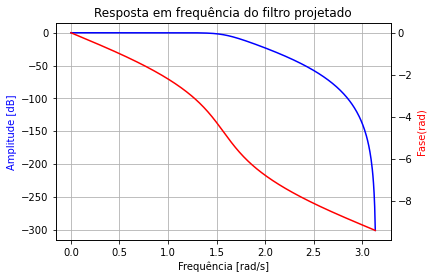

In [127]:
N = 6
Wn = 0.25
num, den = signal.butter(N, Wn, btype='low', analog=False, output='ba', fs=1)
sos = signal.butter(N, Wn, btype='low', analog=False, output='sos', fs=1)

print("Coeficientes do numerador (b's):")
print(num)
print()
print("Coeficientes do denominador (a's):")
print(den)
print()
print("Coeficientes da forma em cascata:")
print(sos)

plotarFreqz(num, den, "Resposta em frequência do filtro projetado")

### 4.2 - Conversão dos coeficientes do numerador e denominador do filtro para Q15

In [128]:
print("Vetor dos numeradores (b's):", num)
print()
num_Q15 = float_to_q15(num)
print("Vetor dos numeradores convertido para Q15:", num_Q15)
print()
# Array no formato CDATA para utilização na placa
print(array_to_cdata(num_Q15))

Vetor dos numeradores (b's): [0.02958822 0.17752934 0.44382335 0.59176447 0.44382335 0.17752934
 0.02958822]

Vetor dos numeradores convertido para Q15: [  969  5817 14543 19390 14543  5817   969]

{
969,
5817,
14543,
19390,
14543,
5817,
969
}



In [129]:
print("Vetor dos denominadores (a's):", den)
print()
den_Q15 = float_to_q15(den)
print("Vetor dos denominadores convertido para Q15:", den_Q15)
print()
# Array no formato CDATA para utilização na placa
print(array_to_cdata(den_Q15))

Vetor dos denominadores (a's): [ 1.00000000e+00 -4.44089210e-16  7.77695962e-01 -1.93655889e-16
  1.14199425e-01 -1.30088375e-17  1.75092596e-03]

Vetor dos denominadores convertido para Q15: [32767     0 25483     0  3742     0    57]

{
32767,
0,
25483,
0,
3742,
0,
57
}



### 4.3 - Implementação do filtro em Forma Direta I

In [130]:
def butterworthIIRTypeI(x, b, a):
    def x_at(n):
        if n < 0:
            return 0
        else:
            return x[n]

    def y_at(n):
        if n < 0:
            return 0
        else:
            return y[n]

    y = np.zeros(128)

    for n in range(128):
        for i in range(N+1):
            y[n] += b[i]* x_at(n - i) 
        for j in range(1, N+1):
            y[n] -= a[j]*y_at(n - j) 
    return y

#### 4.3.1 - Soma de senos

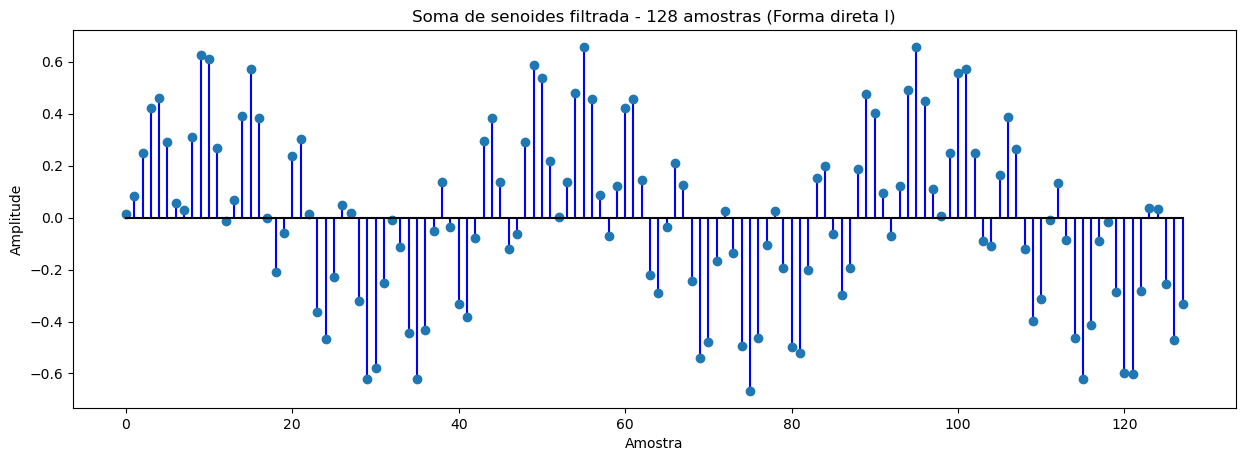

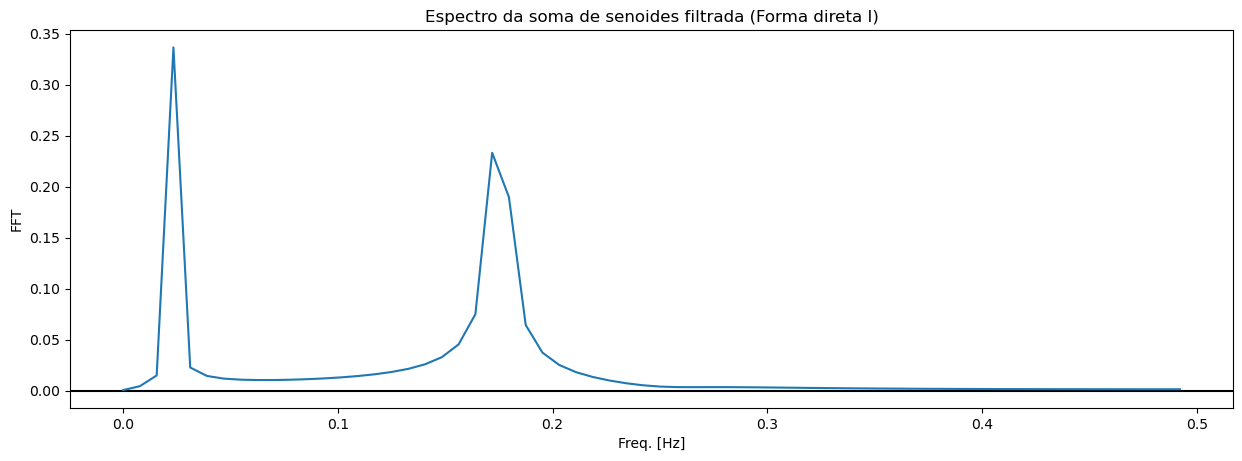

Resultado em float:  [ 1.28206675e-02  8.44323189e-02  2.46490127e-01  4.22106532e-01
  4.58676243e-01  2.89952693e-01  5.52525528e-02  2.75550815e-02
  3.08434042e-01  6.24379286e-01  6.09654589e-01  2.69299158e-01
 -1.27725550e-02  6.72439836e-02  3.91488396e-01  5.72649031e-01
  3.84629667e-01 -2.11036308e-03 -2.09795316e-01 -5.89787099e-02
  2.37391107e-01  3.04000690e-01  1.48147477e-02 -3.64810892e-01
 -4.67570431e-01 -2.27619597e-01  4.77513859e-02  1.70991297e-02
 -3.19633404e-01 -6.20883061e-01 -5.77687156e-01 -2.51838595e-01
 -7.69560049e-03 -1.12598744e-01 -4.43612292e-01 -6.22491111e-01
 -4.30816553e-01 -5.01753353e-02  1.36466032e-01 -3.58681877e-02
 -3.33995324e-01 -3.83305446e-01 -7.96966773e-02  2.95235806e-01
  3.81974558e-01  1.36417014e-01 -1.22875974e-01 -6.50773452e-02
  2.88985583e-01  5.88836868e-01  5.37973369e-01  2.18454939e-01
  3.40936017e-04  1.35334895e-01  4.80455705e-01  6.54725597e-01
  4.57184976e-01  8.74724577e-02 -7.27462769e-02  1.21998633e-01
  4.

In [131]:
y_sin = butterworthIIRTypeI(input_array, num, den)
plotarAmostras(y_sin, "Soma de senoides filtrada - 128 amostras (Forma direta I)")
plotarSinalFreq(y_sin, 128, 1, "Espectro da soma de senoides filtrada (Forma direta I)")
print("Resultado em float: ", y_sin)
print()
print("Resultado em Q15: ", float_to_q15(y_sin))

#### 4.3.2 - Sinal aleatório

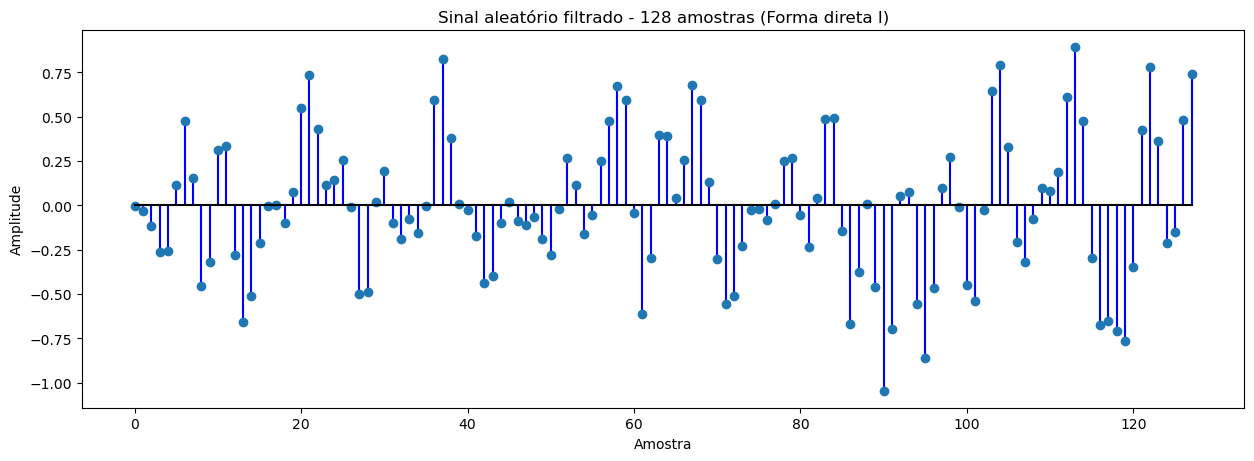

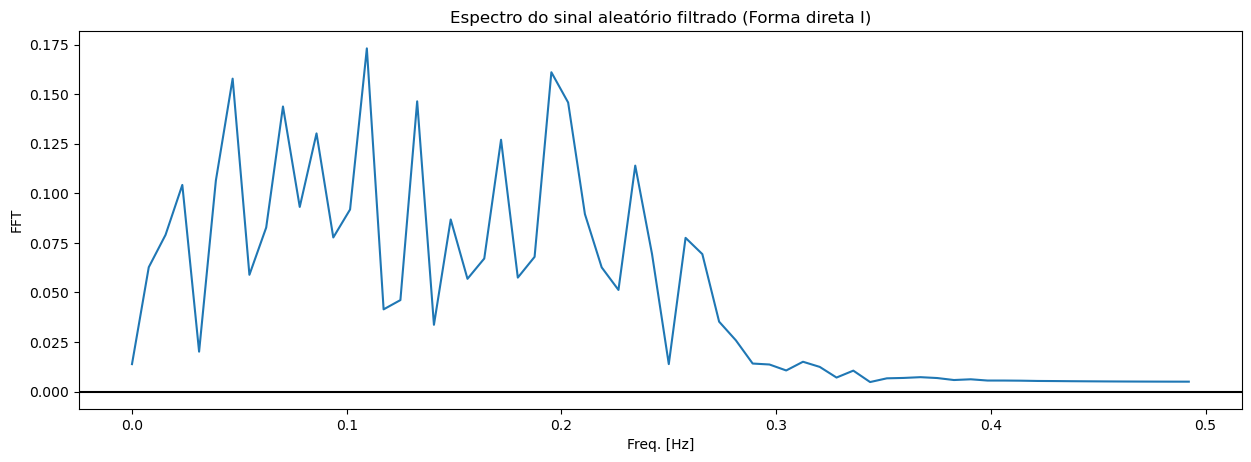

Resultado em float:  [-0.00384627 -0.02907392 -0.11479198 -0.25953948 -0.25779785  0.11822061
  0.47872449  0.15386806 -0.45415703 -0.31949904  0.31312851  0.33527809
 -0.28149112 -0.65880346 -0.51323634 -0.2112644  -0.00517003  0.00460639
 -0.09935593  0.07486843  0.54861721  0.73834703  0.43315428  0.11508853
  0.14195828  0.25488899 -0.0101557  -0.49664242 -0.48756497  0.02208989
  0.19247055 -0.10138031 -0.18627307 -0.07790525 -0.15657474 -0.00349829
  0.59661054  0.82672008  0.37931537  0.00786579 -0.02360809 -0.1736708
 -0.43899795 -0.39773094 -0.10088462  0.01724752 -0.08878684 -0.10970969
 -0.06540028 -0.18666697 -0.27740956 -0.02141466  0.26599177  0.11554972
 -0.15829532 -0.05282859  0.24848327  0.47665555  0.67379719  0.59501565
 -0.03978543 -0.6140889  -0.29445961  0.39579881  0.39086217  0.04395184
  0.2536984   0.67833444  0.59380241  0.13340882 -0.30067399 -0.55564142
 -0.50894571 -0.22951879 -0.02311984 -0.01933292 -0.08348112  0.0066451
  0.24917958  0.26510585 -0.0558

In [132]:
y_random = butterworthIIRTypeI(random_samples, num, den)
plotarAmostras(y_random, "Sinal aleatório filtrado - 128 amostras (Forma direta I)")
plotarSinalFreq(y_random, 128, 1, "Espectro do sinal aleatório filtrado (Forma direta I)")
print("Resultado em float: ", y_random)
print()
print("Resultado em Q15: ", float_to_q15(y_random))

### 4.4 - Implementação do filtro em Forma Direta II

In [133]:
def butterworthIIRTypeII(x, b, a):
    def x_at(n):
        if n < 0:
            return 0
        else:
            return x[n]
    
    def v_at(n):
        if n < 0:
            return 0
        else:
            return v[n]    
        
    v = np.zeros(128)
    y = np.zeros(128)
    
    for n in range(128):
        v[n] = x_at(n) 
        for i in range(1, N+1):
            v[n] += -a[i]*v_at(n - i) 
        for j in range(N+1):
            y[n] += b[j]*v_at(n - j)     
    return y

#### 4.4.1 - Soma de senos

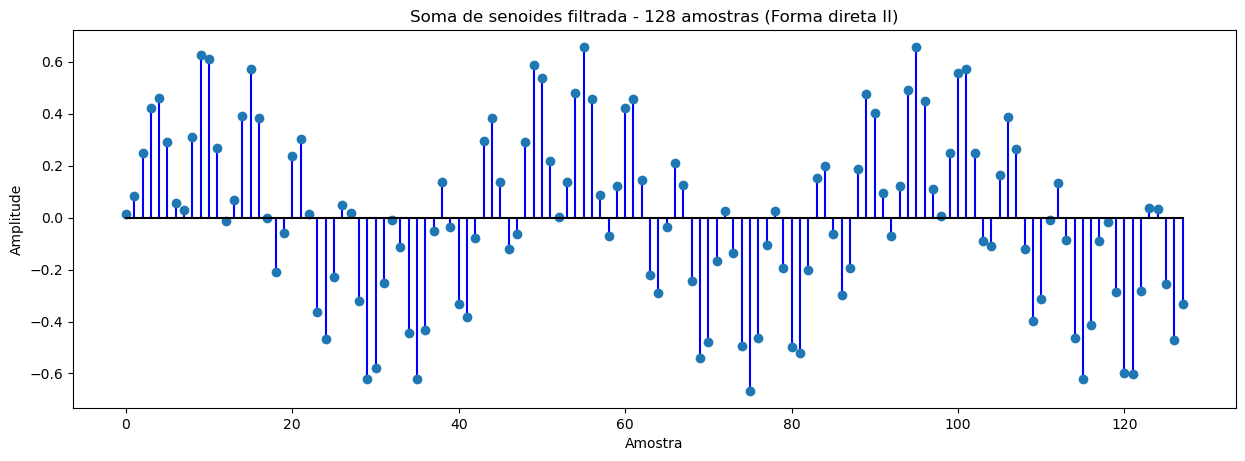

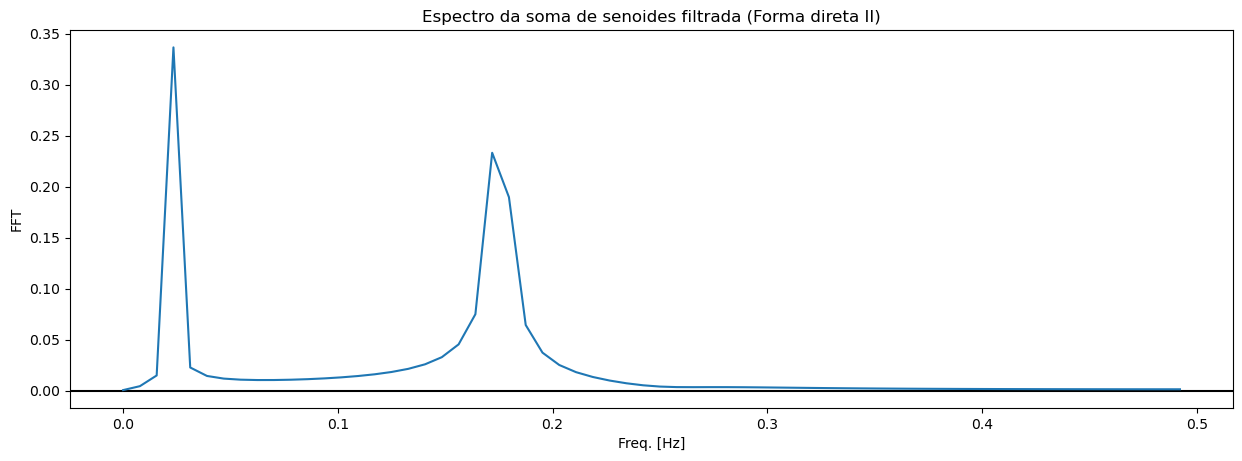

Resultado em float:  [ 1.28206675e-02  8.44323189e-02  2.46490127e-01  4.22106532e-01
  4.58676243e-01  2.89952693e-01  5.52525528e-02  2.75550815e-02
  3.08434042e-01  6.24379286e-01  6.09654589e-01  2.69299158e-01
 -1.27725550e-02  6.72439836e-02  3.91488396e-01  5.72649031e-01
  3.84629667e-01 -2.11036308e-03 -2.09795316e-01 -5.89787099e-02
  2.37391107e-01  3.04000690e-01  1.48147477e-02 -3.64810892e-01
 -4.67570431e-01 -2.27619597e-01  4.77513859e-02  1.70991297e-02
 -3.19633404e-01 -6.20883061e-01 -5.77687156e-01 -2.51838595e-01
 -7.69560049e-03 -1.12598744e-01 -4.43612292e-01 -6.22491111e-01
 -4.30816553e-01 -5.01753353e-02  1.36466032e-01 -3.58681877e-02
 -3.33995324e-01 -3.83305446e-01 -7.96966773e-02  2.95235806e-01
  3.81974558e-01  1.36417014e-01 -1.22875974e-01 -6.50773452e-02
  2.88985583e-01  5.88836868e-01  5.37973369e-01  2.18454939e-01
  3.40936017e-04  1.35334895e-01  4.80455705e-01  6.54725597e-01
  4.57184976e-01  8.74724577e-02 -7.27462769e-02  1.21998633e-01
  4.

In [134]:
y_sin = butterworthIIRTypeII(input_array, num, den)
plotarAmostras(y_sin, "Soma de senoides filtrada - 128 amostras (Forma direta II)")
plotarSinalFreq(y_sin, 128, 1, "Espectro da soma de senoides filtrada (Forma direta II)")
print("Resultado em float: ", y_sin)
print()
print("Resultado em Q15: ", float_to_q15(y_sin))

#### 4.4.2 - Sinal aleatório

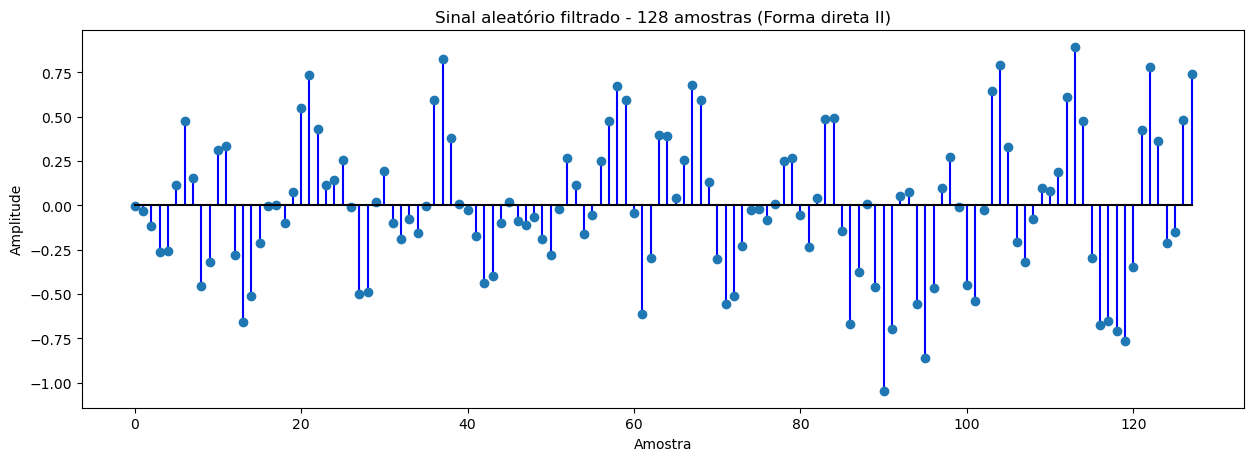

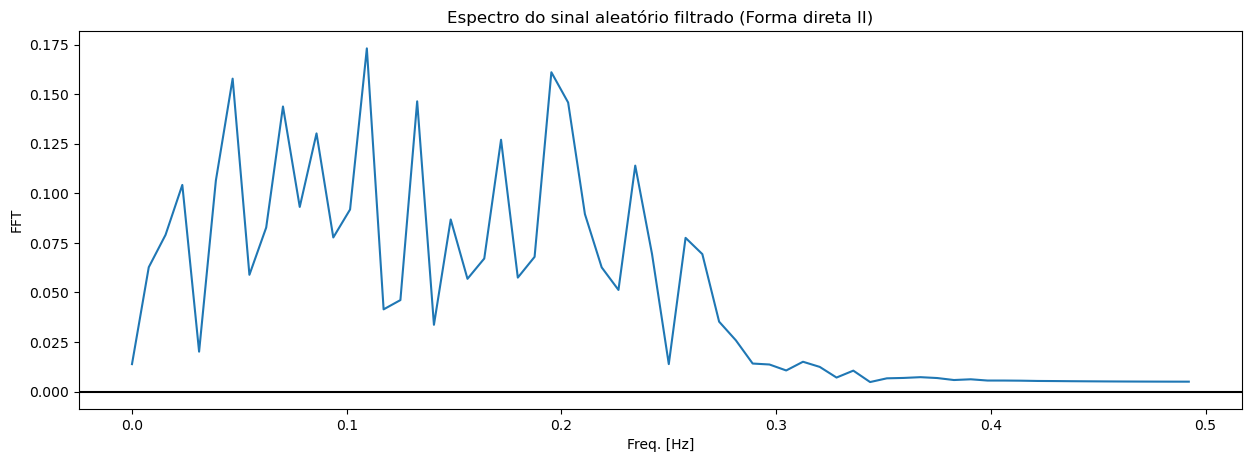

Resultado em float:  [-0.00384627 -0.02907392 -0.11479198 -0.25953948 -0.25779785  0.11822061
  0.47872449  0.15386806 -0.45415703 -0.31949904  0.31312851  0.33527809
 -0.28149112 -0.65880346 -0.51323634 -0.2112644  -0.00517003  0.00460639
 -0.09935593  0.07486843  0.54861721  0.73834703  0.43315428  0.11508853
  0.14195828  0.25488899 -0.0101557  -0.49664242 -0.48756497  0.02208989
  0.19247055 -0.10138031 -0.18627307 -0.07790525 -0.15657474 -0.00349829
  0.59661054  0.82672008  0.37931537  0.00786579 -0.02360809 -0.1736708
 -0.43899795 -0.39773094 -0.10088462  0.01724752 -0.08878684 -0.10970969
 -0.06540028 -0.18666697 -0.27740956 -0.02141466  0.26599177  0.11554972
 -0.15829532 -0.05282859  0.24848327  0.47665555  0.67379719  0.59501565
 -0.03978543 -0.6140889  -0.29445961  0.39579881  0.39086217  0.04395184
  0.2536984   0.67833444  0.59380241  0.13340882 -0.30067399 -0.55564142
 -0.50894571 -0.22951879 -0.02311984 -0.01933292 -0.08348112  0.0066451
  0.24917958  0.26510585 -0.0558

In [135]:
y_random = butterworthIIRTypeII(random_samples, num, den)
plotarAmostras(y_random, "Sinal aleatório filtrado - 128 amostras (Forma direta II)")
plotarSinalFreq(y_random, 128, 1, "Espectro do sinal aleatório filtrado (Forma direta II)")
print("Resultado em float: ", y_random)
print()
print("Resultado em Q15: ", float_to_q15(y_random))

In [136]:
# secoes de segunda ordem já divididas por 2 no numerador
sos = [[ 0.0295882236, 0.0591764473, 0.0295882236, 1.00000000, -0.000000000000000111022302, 0.0173323801],
 [ 0.5 , 1 , 0.5 , 1, -0.000000000000000111022302, 0.171572875],
 [ 0.5, 1,  0.5, 1, -0.000000000000000222044605, 0.588790706]]

print(sos)
print(float_to_q15(sos))

y = signal.sosfilt(sos, input_array)

print(float_to_q15(y))

[[0.0295882236, 0.0591764473, 0.0295882236, 1.0, -1.11022302e-16, 0.0173323801], [0.5, 1, 0.5, 1, -1.11022302e-16, 0.171572875], [0.5, 1, 0.5, 1, -2.22044605e-16, 0.588790706]]
[[  969  1939   969 32767     0   567]
 [16384 32767 16384 32767     0  5622]
 [16384 32767 16384 32767     0 19293]]
[  105   691  2019  3457  3757  2375   452   225  2526  5114  4994  2206
  -104   550  3207  4691  3150   -17 -1718  -483  1944  2490   121 -2988
 -3830 -1864   391   140 -2618 -5086 -4732 -2063   -63  -922 -3634 -5099
 -3529  -411  1117  -293 -2736 -3140  -652  2418  3129  1117 -1006  -533
  2367  4823  4407  1789     2  1108  3935  5363  3745   716  -595   999
  3457  3746  1179 -1823 -2381  -305  1703  1027 -1990 -4412 -3921 -1355
   218 -1128 -4063 -5453 -3799  -880   197 -1592 -4078 -4272 -1654  1247
  1628  -528 -2440 -1586  1518  3880  3299   778  -587   987  4016  5363
  3681   886    53  2045  4565  4680  2040  -731  -911  1343  3175  2169
  -991 -3263 -2574   -88  1083  -702 -3805 -5098

### 4.5 - Implementação do filtro em Forma Direta I Transposta **(FAZER)**

### 4.6 - Implementação do filtro em Forma Direta II Transposta

In [137]:
def butterworthIIRTypeIITransposed(x, b, a):
    def x_at(n):
        if n < 0:
            return 0
        else:
            return x[n]

    def y_at(n):
        if n < 0:
            return 0
        else:
            return y[n]

    y = np.zeros(128)

    for n in range(128):
        y[n] += b[0]*x_at(n)
        for i in range(1, N+1):
            y[n] += (-a[i]*y_at(n - i)) + (b[i]*x_at(n - i))

    return y

#### 4.6.1 - Soma de senos

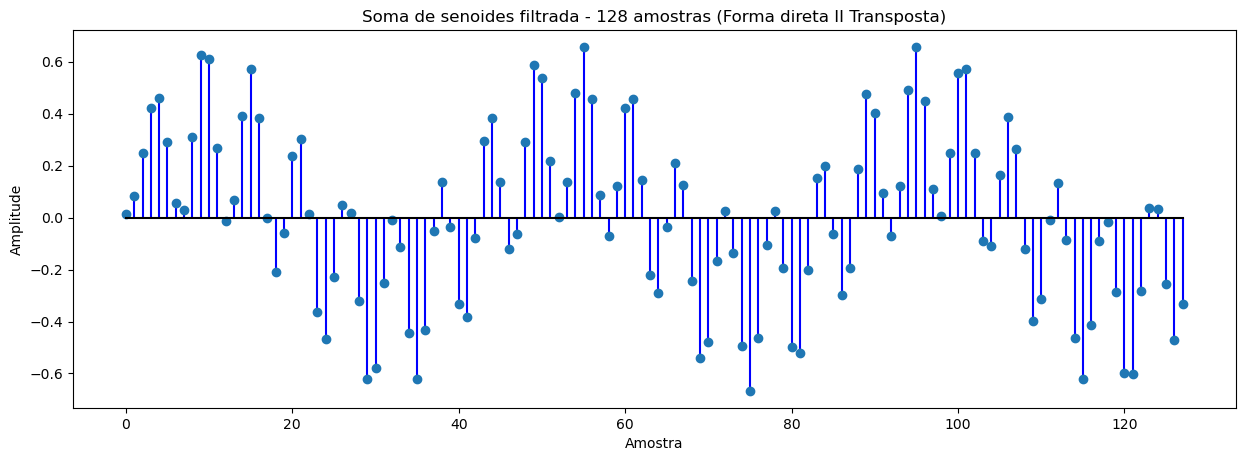

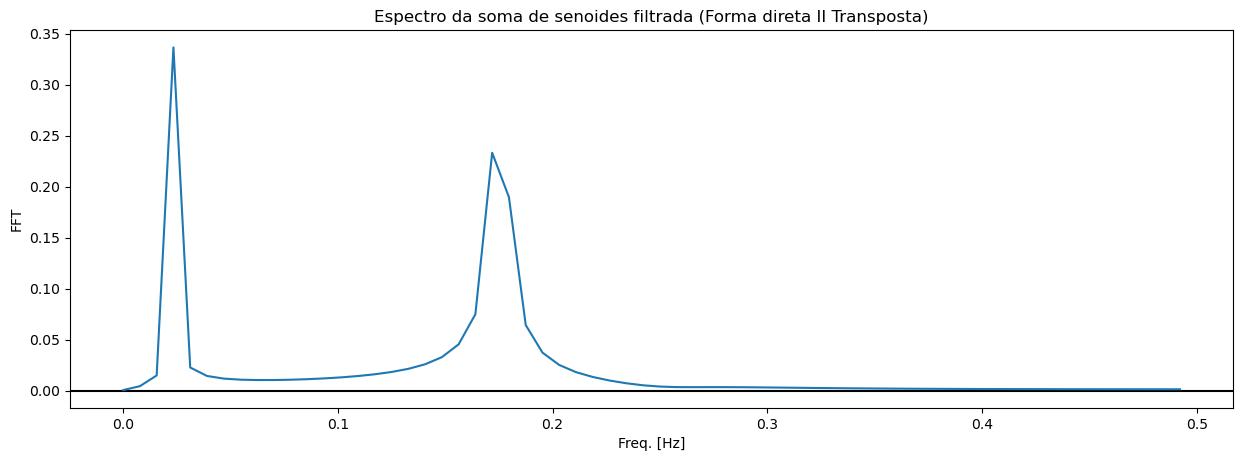

Resultado em float:  [ 1.28206675e-02  8.44323189e-02  2.46490127e-01  4.22106532e-01
  4.58676243e-01  2.89952693e-01  5.52525528e-02  2.75550815e-02
  3.08434042e-01  6.24379286e-01  6.09654589e-01  2.69299158e-01
 -1.27725550e-02  6.72439836e-02  3.91488396e-01  5.72649031e-01
  3.84629667e-01 -2.11036308e-03 -2.09795316e-01 -5.89787099e-02
  2.37391107e-01  3.04000690e-01  1.48147477e-02 -3.64810892e-01
 -4.67570431e-01 -2.27619597e-01  4.77513859e-02  1.70991297e-02
 -3.19633404e-01 -6.20883061e-01 -5.77687156e-01 -2.51838595e-01
 -7.69560049e-03 -1.12598744e-01 -4.43612292e-01 -6.22491111e-01
 -4.30816553e-01 -5.01753353e-02  1.36466032e-01 -3.58681877e-02
 -3.33995324e-01 -3.83305446e-01 -7.96966773e-02  2.95235806e-01
  3.81974558e-01  1.36417014e-01 -1.22875974e-01 -6.50773452e-02
  2.88985583e-01  5.88836868e-01  5.37973369e-01  2.18454939e-01
  3.40936017e-04  1.35334895e-01  4.80455705e-01  6.54725597e-01
  4.57184976e-01  8.74724577e-02 -7.27462769e-02  1.21998633e-01
  4.

In [138]:
y_sin = butterworthIIRTypeIITransposed(input_array, num, den)
plotarAmostras(y_sin, "Soma de senoides filtrada - 128 amostras (Forma direta II Transposta)")
plotarSinalFreq(y_sin, 128, 1, "Espectro da soma de senoides filtrada (Forma direta II Transposta)")
print("Resultado em float: ", y_sin)
print()
print("Resultado em Q15: ", float_to_q15(y_sin))

#### 4.6.2 - Sinal aleatório

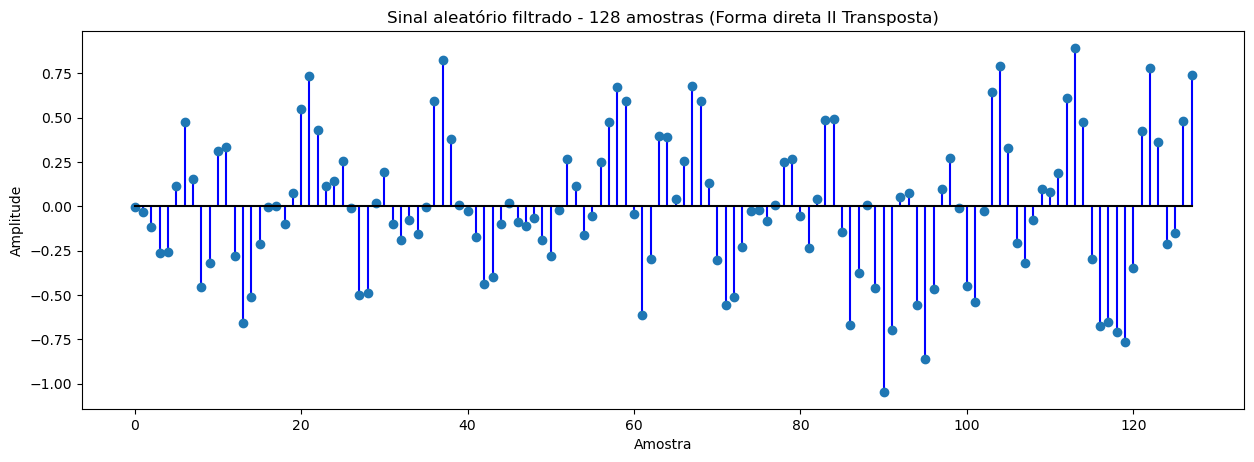

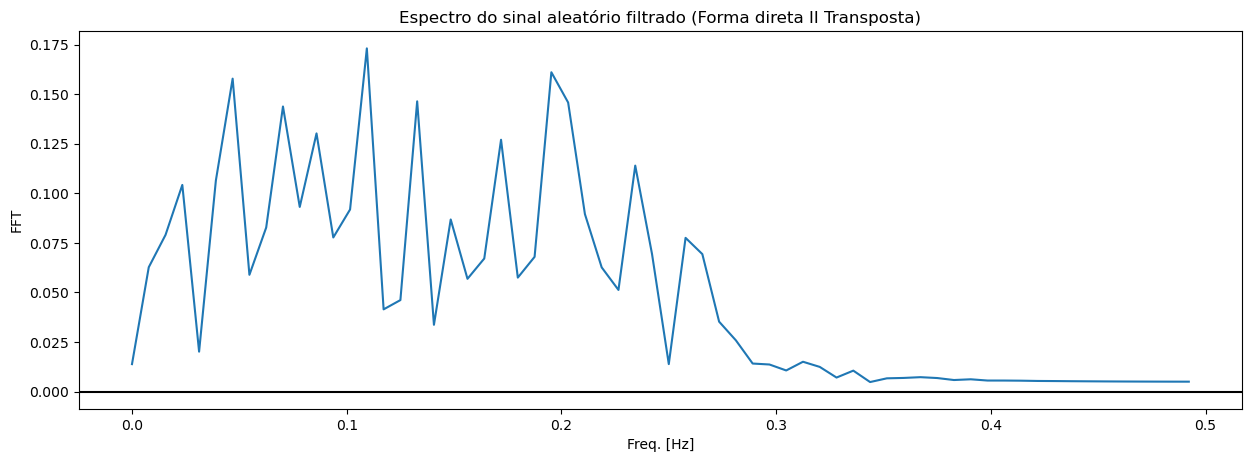

Resultado em float:  [-0.00384627 -0.02907392 -0.11479198 -0.25953948 -0.25779785  0.11822061
  0.47872449  0.15386806 -0.45415703 -0.31949904  0.31312851  0.33527809
 -0.28149112 -0.65880346 -0.51323634 -0.2112644  -0.00517003  0.00460639
 -0.09935593  0.07486843  0.54861721  0.73834703  0.43315428  0.11508853
  0.14195828  0.25488899 -0.0101557  -0.49664242 -0.48756497  0.02208989
  0.19247055 -0.10138031 -0.18627307 -0.07790525 -0.15657474 -0.00349829
  0.59661054  0.82672008  0.37931537  0.00786579 -0.02360809 -0.1736708
 -0.43899795 -0.39773094 -0.10088462  0.01724752 -0.08878684 -0.10970969
 -0.06540028 -0.18666697 -0.27740956 -0.02141466  0.26599177  0.11554972
 -0.15829532 -0.05282859  0.24848327  0.47665555  0.67379719  0.59501565
 -0.03978543 -0.6140889  -0.29445961  0.39579881  0.39086217  0.04395184
  0.2536984   0.67833444  0.59380241  0.13340882 -0.30067399 -0.55564142
 -0.50894571 -0.22951879 -0.02311984 -0.01933292 -0.08348112  0.0066451
  0.24917958  0.26510585 -0.0558

In [139]:
y_random = butterworthIIRTypeIITransposed(random_samples, num, den)
plotarAmostras(y_random, "Sinal aleatório filtrado - 128 amostras (Forma direta II Transposta)")
plotarSinalFreq(y_random, 128, 1, "Espectro do sinal aleatório filtrado (Forma direta II Transposta)")
print("Resultado em float: ", y_random)
print()
print("Resultado em Q15: ", float_to_q15(y_random))

### 4.7 - Implementação do filtro em Cascata

#### 4.7.1 - Soma de senos

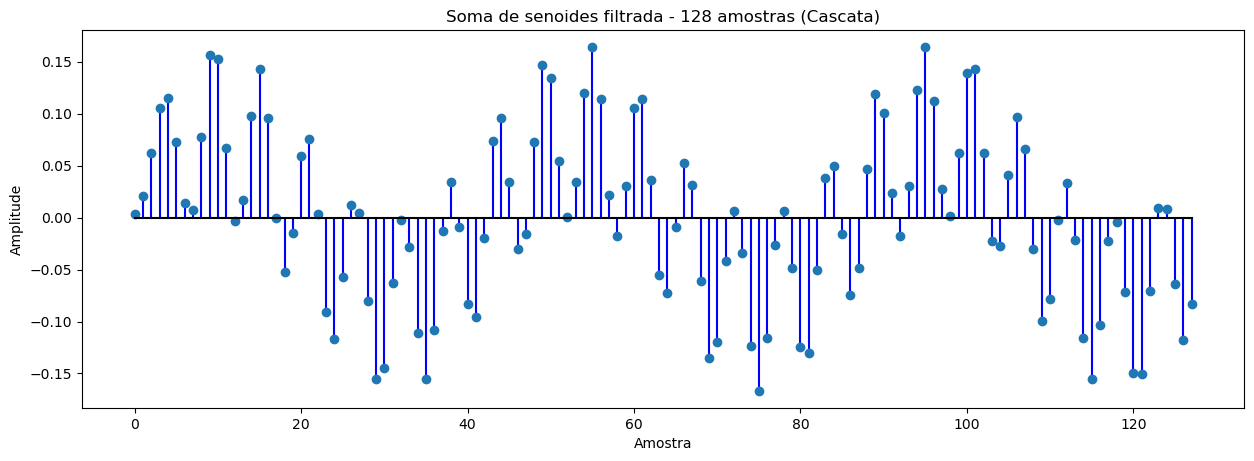

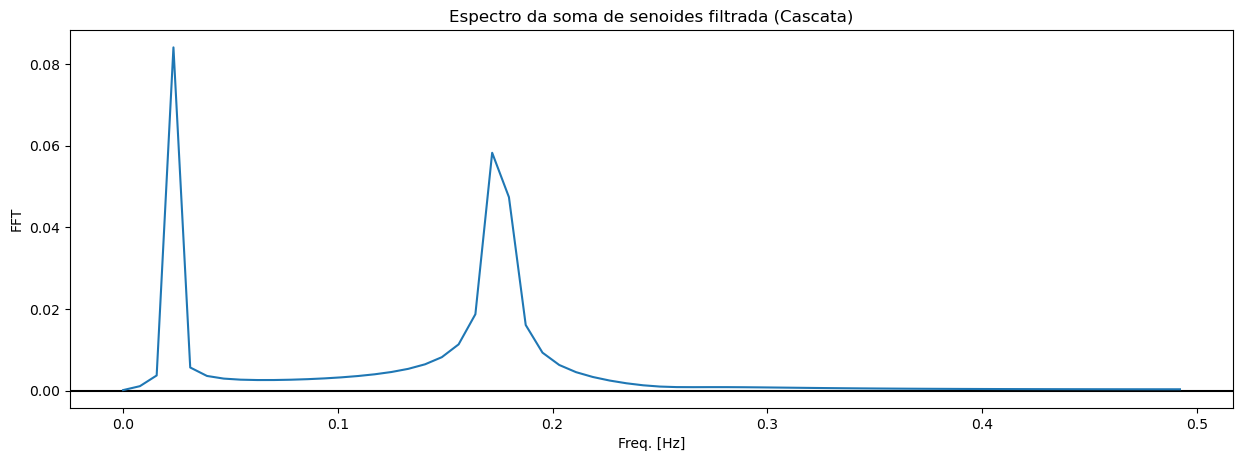

Resultado em float:  [ 3.20516686e-03  2.11080797e-02  6.16225317e-02  1.05526633e-01
  1.14669061e-01  7.24881734e-02  1.38131383e-02  6.88877038e-03
  7.71085105e-02  1.56094821e-01  1.52413647e-01  6.73247897e-02
 -3.19313868e-03  1.68109959e-02  9.78720990e-02  1.43162258e-01
  9.61574168e-02 -5.27590685e-04 -5.24488290e-02 -1.47446775e-02
  5.93477767e-02  7.60001725e-02  3.70368700e-03 -9.12027230e-02
 -1.16892608e-01 -5.69048994e-02  1.19378464e-02  4.27478243e-03
 -7.99083508e-02 -1.55220765e-01 -1.44421789e-01 -6.29596489e-02
 -1.92390017e-03 -2.81496860e-02 -1.10903073e-01 -1.55622778e-01
 -1.07704138e-01 -1.25438339e-02  3.41165079e-02 -8.96704688e-03
 -8.34988310e-02 -9.58263616e-02 -1.99241694e-02  7.38089513e-02
  9.54936396e-02  3.41042535e-02 -3.07189936e-02 -1.62693363e-02
  7.22463956e-02  1.47209217e-01  1.34493342e-01  5.46137348e-02
  8.52340444e-05  3.38337237e-02  1.20113926e-01  1.63681399e-01
  1.14296244e-01  2.18681145e-02 -1.81865692e-02  3.04996583e-02
  1.

In [140]:
y_sin = signal.sosfilt(sos, input_array)
plotarAmostras(y_sin, "Soma de senoides filtrada - 128 amostras (Cascata)")
plotarSinalFreq(y_sin, 128, 1, "Espectro da soma de senoides filtrada (Cascata)")
print("Resultado em float: ", y_sin)
print()
print("Resultado em Q15: ", float_to_q15(y_sin))

#### 4.7.2 - Sinal aleatório

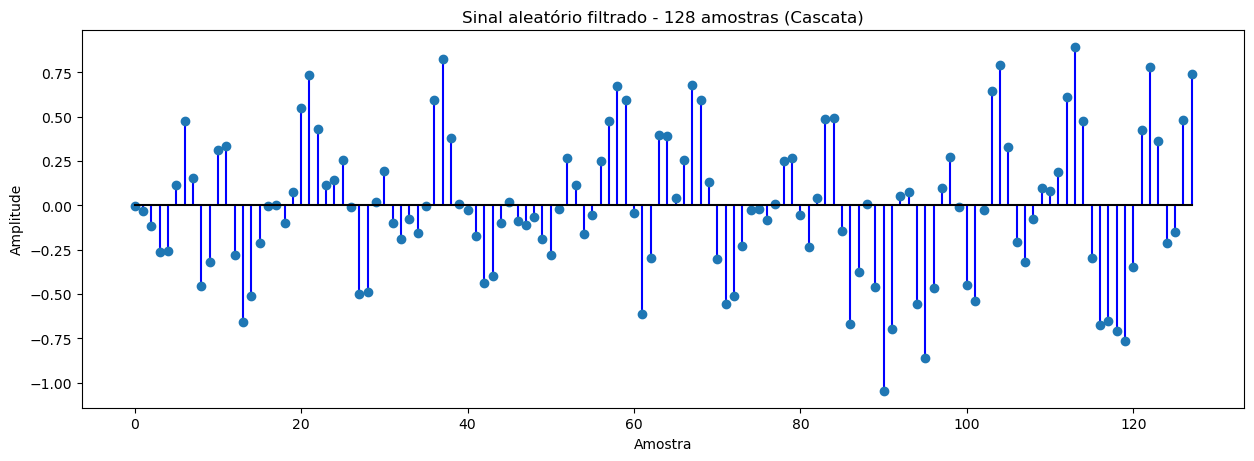

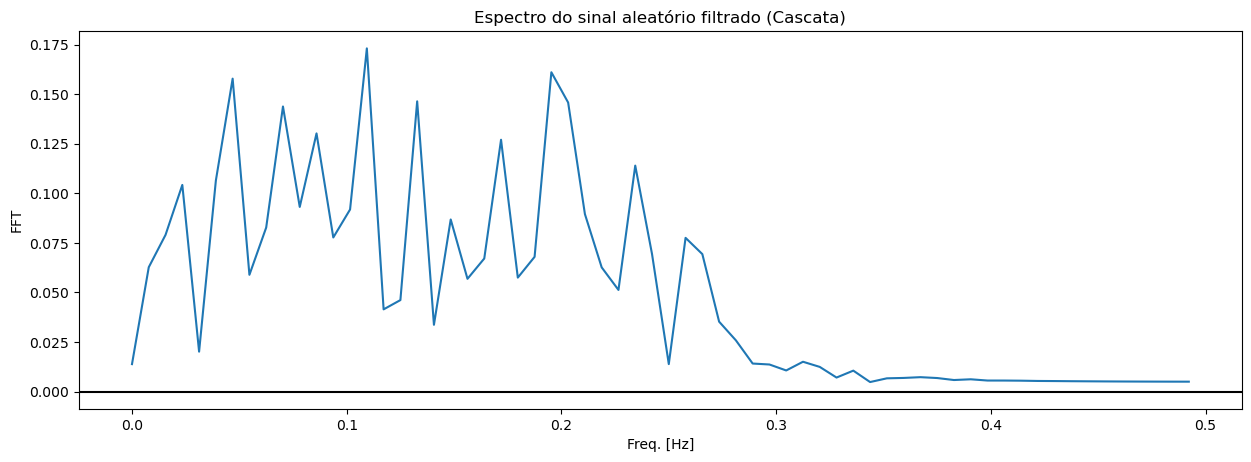

Resultado em float:  [-0.00096157 -0.00726848 -0.02869799 -0.06488487 -0.06444946  0.02955515
  0.11968112  0.03846702 -0.11353926 -0.07987476  0.07828213  0.08381952
 -0.07037278 -0.16470087 -0.12830909 -0.0528161  -0.00129251  0.0011516
 -0.02483898  0.01871711  0.1371543   0.18458676  0.10828857  0.02877213
  0.03548957  0.06372225 -0.00253892 -0.1241606  -0.12189124  0.00552247
  0.04811764 -0.02534508 -0.04656827 -0.01947631 -0.03914369 -0.00087457
  0.14915263  0.20668002  0.09482884  0.00196645 -0.00590202 -0.0434177
 -0.10974949 -0.09943273 -0.02522116  0.00431188 -0.02219671 -0.02742742
 -0.01635007 -0.04666674 -0.06935239 -0.00535367  0.06649794  0.02888743
 -0.03957383 -0.01320715  0.06212082  0.11916389  0.1684493   0.14875391
 -0.00994636 -0.15352223 -0.0736149   0.0989497   0.09771554  0.01098796
  0.0634246   0.16958361  0.1484506   0.0333522  -0.0751685  -0.13891035
 -0.12723643 -0.0573797  -0.00577996 -0.00483323 -0.02087028  0.00166128
  0.06229489  0.06627646 -0.0139

In [141]:
y_sin = signal.sosfilt(sos, random_samples)
plotarAmostras(y_random, "Sinal aleatório filtrado - 128 amostras (Cascata)")
plotarSinalFreq(y_random, 128, 1, "Espectro do sinal aleatório filtrado (Cascata)")
print("Resultado em float: ", y_sin)
print()
print("Resultado em Q15: ", float_to_q15(y_sin))

### 4.8 - Implementação do filtro em Forma Paralela **(FAZER)**